In [1]:
import sys
print(sys.executable)
print(sys.prefix)

/venv/main/bin/python
/venv/main


In [2]:
import os
from datasets import load_dataset

from src.config import config_medgemma_4b_it_nct_crc_he
from src.utils.fetch_data import load_data_nct_crc_he


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Load the Zenodo NCT-CRC-HE 100k Dataset

In [3]:
dataset = load_data_nct_crc_he(test_size=0.025, val_size=0.025, max_examples=25000)
print(dataset)

Resolving data files:   0%|          | 0/100000 [00:00<?, ?it/s]

Dataset structure
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
})
Dataset structure after splitting
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 23750
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 625
    })
})
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 23750
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 625
    })
})


## Fine tune medgemma-4b-it on the NCT-CRC-HE 100K Data


In [4]:
from src.utils.data_utils import format_data_medgemma_nct_crc_he
from src.utils.model_utils import load_model_and_processor
from src.config import config_medgemma_4b_it_nct_crc_he
from src.peft_medgemma_4b_it_nct_crc_he import fine_tune_medgemma_nct_crc_he

# Format the dataset
formatted_dataset = dataset.map(format_data_medgemma_nct_crc_he)

# Load base model and processor
base_model, processor = load_model_and_processor(
    model_id=config_medgemma_4b_it_nct_crc_he.base_model_id,
    model_directory=config_medgemma_4b_it_nct_crc_he.model_folder_base,
    model_kwargs=config_medgemma_4b_it_nct_crc_he.model_kwargs,
)

Map:   0%|          | 0/23750 [00:00<?, ? examples/s]

Map:   0%|          | 0/625 [00:00<?, ? examples/s]

Map:   0%|          | 0/625 [00:00<?, ? examples/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it


In [5]:
config_medgemma_4b_it_nct_crc_he.model_kwargs

{'attn_implementation': 'eager',
 'torch_dtype': torch.bfloat16,
 'device_map': 'auto'}

In [6]:
# Fine-tune the model
fine_tune_medgemma_nct_crc_he(
    model=base_model,
    processor=processor,
    data=formatted_dataset,
    base_model_directory=config_medgemma_4b_it_nct_crc_he.model_folder_base,
    save_directory_adapters=config_medgemma_4b_it_nct_crc_he.model_folder_crc_ft_adapter,
    save_directory_full_model=config_medgemma_4b_it_nct_crc_he.model_folder_crc_ft_full,
    model_kwargs=config_medgemma_4b_it_nct_crc_he.model_kwargs,
)

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
250,0.314800,0.015384,0.049865,1460028.000000,0.989870
500,0.014200,0.013741,0.009609,2920049.000000,0.990414
750,0.013700,0.013828,0.015564,4380072.000000,0.990473
1000,0.013600,0.013337,0.019605,5840136.000000,0.990621
1250,0.013400,0.013272,0.016324,7300234.000000,0.990562


Fine-tuned model adapters and processor saved to /workspace/meda-main/models/medgemma-4b-it-nct-crc-he-adapter


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it


## Test the baseline model

In [7]:
from src.test_medgemma_49_it_nct_crc_he import test_medgemma_4b_it_nct_crc_he
from src.utils.prompt_utils import make_prompt_without_image
import src.config.config_medgemma_4b_it_nct_crc_he as config_medgemma_4b_it_nct_crc_he


test_instance_base = test_medgemma_4b_it_nct_crc_he(
    model_id=config_medgemma_4b_it_nct_crc_he.base_model_id,
    model_folder=config_medgemma_4b_it_nct_crc_he.model_folder_base,
    model_kwargs=config_medgemma_4b_it_nct_crc_he.model_kwargs,
    max_new_tokens=500
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it


In [18]:
messages = make_prompt_without_image(
        system_message=config_medgemma_4b_it_nct_crc_he.prompt_template["system_message"],
        user_prompt=config_medgemma_4b_it_nct_crc_he.prompt_template["user_prompt"])
print(f"System Message:{config_medgemma_4b_it_nct_crc_he.prompt_template['system_message']}")
print(f"User Message:{config_medgemma_4b_it_nct_crc_he.prompt_template['user_prompt']}")
print(f"True finding:{config_medgemma_4b_it_nct_crc_he.condition_findings[dataset['test'][-6]['label']]}")

System Message:You are a medical AI expert analyzing image patches from hematoxylin & eosin     stained histological images of human colorectal cancer (CRC) and normal tissue.
User Message:What is the most likely tissue type shown in the histopathology image? 
 A: adipose
B: background
C: debris
D: lymphocytes
E: mucus
F: smooth muscle
G: normal colon mucosa
H: cancer-associated stroma
I: colorectal adenocarcinoma epithelium
True finding:H: cancer-associated stroma


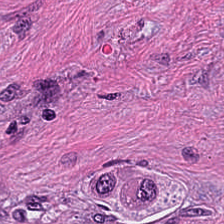

In [19]:
dataset["test"][-6]["image"].show()

In [20]:
base_assistant_message = test_instance_base.chat_v1(messages, dataset["test"][-6]["image"])

print(f"Baseline assistant message:{base_assistant_message}")

Generated Description: 
Based on the image, the most likely tissue type is **I: colorectal adenocarcinoma epithelium**.

Here's why:

*   **Cellular morphology:** The image shows cells with a distinct morphology, including nuclei with prominent nucleoli and a relatively irregular shape. This is characteristic of epithelial cells.
*   **Presence of glands:** The image shows some structures that resemble glands, which are a hallmark of glandular epithelium.
*   **Context:** The image is from a histopathology slide, which is a microscopic view of tissue. The presence of cells with the described morphology in a tissue context strongly suggests a neoplastic process.

While other options are possible, they are less likely given the overall appearance of the image. For example, "normal colon mucosa" would show a more organized and uniform appearance. "Cancer-associated stroma" would show a more fibrous and disorganized structure.

Therefore, the most probable answer is **I: colorectal adenoca

## Test the fine-tuned model


In [21]:
test_instance_peft = test_medgemma_4b_it_nct_crc_he(
    model_id="peft",
    model_folder=config_medgemma_4b_it_nct_crc_he.model_folder_crc_ft_full,
    model_kwargs=config_medgemma_4b_it_nct_crc_he.model_kwargs,
    max_new_tokens=500
)
messages = make_prompt_without_image(
        system_message=config_medgemma_4b_it_nct_crc_he.prompt_template["system_message"],
        user_prompt=config_medgemma_4b_it_nct_crc_he.prompt_template["user_prompt"])
print(f"System Message:{config_medgemma_4b_it_nct_crc_he.prompt_template['system_message']}")
print(f"User Message:{config_medgemma_4b_it_nct_crc_he.prompt_template['user_prompt']}")
print(f"True finding:{config_medgemma_4b_it_nct_crc_he.condition_findings[dataset['test'][-6]['label']]}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it-nct-crc-he-finetuned-merged
System Message:You are a medical AI expert analyzing image patches from hematoxylin & eosin     stained histological images of human colorectal cancer (CRC) and normal tissue.
User Message:What is the most likely tissue type shown in the histopathology image? 
 A: adipose
B: background
C: debris
D: lymphocytes
E: mucus
F: smooth muscle
G: normal colon mucosa
H: cancer-associated stroma
I: colorectal adenocarcinoma epithelium
True finding:H: cancer-associated stroma


In [22]:
config_medgemma_4b_it_nct_crc_he.model_folder_crc_ft_full

'/workspace/meda-main/models/medgemma-4b-it-nct-crc-he-finetuned-merged'

In [23]:
ft_assistant_message = test_instance_peft.chat_v1(messages, dataset["test"][-6]["image"])
print(f"Fine-tuned assistant message:{ft_assistant_message}")

Generated Description: 
H: cancer-associated stroma
Fine-tuned assistant message:
H: cancer-associated stroma


## Test the augmented summary agent 

In [24]:
augmented_user_prompt = (config_medgemma_4b_it_nct_crc_he.prompt_template["user_prompt"]
                             + f"\nIn your answer, please consider that a fine-tuned model ML model on "
                               f"\ncimage patches from hematoxylin & eosin \
    stained histological images of human colorectal cancer (CRC) and normal tissue has predicted  **{ft_assistant_message}**  in this case. "
                               f"\nProvide a detailed explanation for your diagnosis.")
    
augmented_messages = make_prompt_without_image(
        system_message=config_medgemma_4b_it_nct_crc_he.prompt_template["system_message"],
        user_prompt=augmented_user_prompt)
# augmented_assistant_message = test_instance_base.chat(augmented_messages)
augmented_assistant_message = test_instance_base.chat_v1(augmented_messages, dataset["test"][-6]["image"])

print(f"Augmented-tuned assistant message:{augmented_assistant_message}")

Generated Description: 

Based on the provided image and the context of a fine-tuned ML model trained on CRC and normal tissue, the most likely tissue type is **H: cancer-associated stroma**.

Here's a detailed explanation:

*   **Histology and the Image:** The image shows a dense, cellular structure with a mix of cell types. The cells appear to be arranged in a somewhat disorganized manner, with some cells having prominent nuclei and others appearing more amorphous.

*   **Cancer-Associated Stroma:** The stroma is the supporting connective tissue in a tumor. In CRC, the stroma is often altered and infiltrated by cancer cells. It can be composed of fibroblasts, collagen, and other extracellular matrix components. The presence of cancer-associated stroma is a key feature of CRC.

*   **Why other options are less likely:**

    *   **A: Adipose:** Adipose tissue is not typically a prominent feature in CRC.
    *   **B: Background:** While some background tissue is present, the cellularit

In [25]:
## Evaluation

In [30]:
import gc
import torch
# del test_instance_peft, test_instant_base
gc.collect()
torch.cuda.empty_cache()

In [1]:
from src.evaluate_medgemma_4b_it_nct_crc_he import evaluate_medgemma_4b_it_nct_crc_he
import src.config.config_medgemma_4b_it_nct_crc_he as config_medgemma_4b_it_nct_crc_he
from src.utils.fetch_data import load_data_nct_crc_he

model_kwargs = config_medgemma_4b_it_nct_crc_he.model_kwargs
evaluator = evaluate_medgemma_4b_it_nct_crc_he(
    model_id=config_medgemma_4b_it_nct_crc_he.base_model_id,
    model_folder=config_medgemma_4b_it_nct_crc_he.model_folder_base,
    model_kwargs=model_kwargs,
    max_new_tokens=250
)

dataset = load_data_nct_crc_he(test_size=0.025, val_size=0.025, max_examples=25000)
dataset_test = dataset["test"]
#dataset_test = dataset_test.select(list(range(10)) + list(range(len(dataset_test)-10, len(dataset_test), 1)))
accuracy_baseline, f1_baseline = evaluator.evaluate(dataset_test, batch_size=4)

print(f"Base Model Evaluation - Accuracy: {accuracy_baseline}, F1 Score: {f1_baseline}")

import gc
import torch
del evaluator
gc.collect()
torch.clear_autocast_cache()



Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it


Resolving data files:   0%|          | 0/100000 [00:00<?, ?it/s]

Dataset structure
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
})
Dataset structure after splitting
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 23750
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 625
    })
})
Accuracy: 0.0832)
F1 Metric: 0.04660127591706539)
Base Model Evaluation - Accuracy: 0.0832, F1 Score: 0.04660127591706539


In [2]:
evaluator = evaluate_medgemma_4b_it_nct_crc_he(
    model_id="peft",
    model_folder=config_medgemma_4b_it_nct_crc_he.model_folder_crc_ft_full,
    model_kwargs=model_kwargs,
    max_new_tokens=250
)

accuracy_ft, f1_ft = evaluator.evaluate(dataset_test, batch_size=4)

print(f"Fine tuned Model Evaluation - Accuracy: {accuracy_ft}, F1 Score: {f1_ft}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it-nct-crc-he-finetuned-merged
Accuracy: 0.9728)
F1 Metric: 0.9727237858064043)
Fine tuned Model Evaluation - Accuracy: 0.9728, F1 Score: 0.9727237858064043
